In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim


from torch.utils.data import DataLoader
from tabulate import tabulate

from datetime import datetime

import argparse
import os

In [2]:
class ResNetCifarBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(ResNetCifarBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [3]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
def get_dataloader(is_train, batch_size, path='./CIFAR10/'):
    tr_fl = [transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
    te_fl = [transforms.ToTensor()
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
            ]
    tr_fl = transforms.Compose(tr_fl)
    te_fl = transforms.Compose(te_fl)

    if is_train:
        train_data = torchvision.datasets.CIFAR10(path, train=True, download=True, transform=tr_fl)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        return train_loader
    else:
        test_data = torchvision.datasets.CIFAR10(path, train = False, download=True, transform=te_fl)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
        return test_loader

In [31]:
def init_weights(net, gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, gain)
            nn.init.constant_(m.bias.data, 0.0)

    # net.apply(init_func)
    init_func(net)


class ResNetModel(nn.Module):

    def __init__(self, opt, train=True):

        super(ResNetModel, self).__init__()

        self.net = ResNet(ResNetCifarBlock, [3, 6, 4, 3])
        if train:
            self.net.train()
        else:
            self.net.eval()
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            self.net = self.net.to('cuda')
            self.net = torch.nn.DataParallel(self.net)
        else:
            self.device = torch.device('mps')
            self.net = self.net.to('mps')
            self.net = torch.nn.DataParallel(self.net)

        init_weights(self.net)
        num_params = 0
        for param in self.net.parameters():
            num_params += param.numel()

        self.num_params = num_params

        layer_info = []

        for name, param in self.net.named_parameters():
            name = name.split('.')
            name = str(name[-2]) + '.' + str(name[-1])
            layer_info.append([name, param.numel()])

        self.para_table = tabulate(layer_info, headers=['Layers', 'size'], tablefmt='grid')

        self.timestamp = opt.timestamp

        if train:
            self.checkpoint_dir = opt.checkpoint_dir

            assert opt.optimizer in ['SGD', 'Adam', 'ASGD',
                                     'Adagrad'], "Input optimization is not valid, please specify among  ['SGD', 'Adam', 'ASGD', 'Adagrad'] "

            if opt.optimizer == 'SGD':
                self.optimizer = optim.SGD(
                    self.net.parameters(),
                    lr=opt.lr,
                    momentum=opt.momentum,
                    weight_decay=opt.weight_decay
                )
            if opt.optimizer == 'Adam':
                self.optimizer = optim.Adam(
                    self.net.parameters(),
                    lr=opt.lr,
                    weight_decay=opt.weight_decay
                )
            if opt.optimizer == 'Adagrad':
                self.optimizer = optim.Adagrad(
                    self.net.parameters(),
                    lr=opt.lr,
                    #lr_decay=opt.lr_decay,
                    weight_decay=opt.weight_decay
                )
            if opt.optimizer == 'ASGD':
                self.optimizer = optim.ASGD(
                    self.net.parameters(),
                    lr=opt.lr,
                    weight_decay=opt.weight_decay
                )

            self.scheduler = optim.lr_scheduler.StepLR(
                self.optimizer,
                step_size=opt.decay_step,
                gamma=opt.lr_decay_rate
            )
            self.criterion = nn.CrossEntropyLoss()
            self.loss = 0.0

    def optimize_params(self, x, label):
        x = x.to(self.device)
        label = label.to(self.device)
        y = self._forward(x)
        self._update_params(y, label)

    def _forward(self, x):
        x = self.net(x)
        return x

    def _backward(self, y, label):
        self.loss = self.criterion(y, label)
        self.loss.backward()

    def _update_params(self, y, label):
        self.optimizer.zero_grad()
        self._backward(y, label)
        self.optimizer.step()
        self.scheduler.step()  # scheduler step in each iteration

    def test(self, x, label):
        with torch.no_grad():
            x = x.to(self.device)
            label = label.to(self.device)
            outputs = self._forward(x)
            _, predicted = torch.max(outputs.data, 1)
            total = label.size(0)
            correct = (predicted == label).sum().item()
            return correct, total, predicted

    def val(self, x, label):
        with torch.no_grad():
            x = x.to(self.device)
            label = label.to(self.device)
            y = self._forward(x)
            return self.criterion(y, label).item()

    def save_model(self):

        timestamp = self.timestamp
        file_name = 'final_' + timestamp

        path = os.path.join(self.checkpoint_dir, f'{file_name}.pth')
        torch.save(self.net.state_dict(), path)
        print(f'model saved to {path}')

        return path

    def load_model(self, path):
        self.net.load_state_dict(torch.load(path))
        print(f'model loaded from {path}')

    def get_current_loss(self):
        return self.loss.item()

In [6]:
def train(opt):
    print(opt)

    dataloader = get_dataloader(True, opt.batch, opt.dataset_dir)
    model = ResNetModel(opt, train=True)

    num_params = model.num_params

    timestamp = opt.timestamp

    with open(os.path.join(opt.checkpoint_dir, 'log_' + timestamp + '.txt'), 'a') as f:
        f.write(str(opt) + '\n')
        f.write('\nThe total number of parameter is: ' + str(round(num_params / 1e6, 3)) + ' M' + '\n')

    with open(os.path.join(opt.checkpoint_dir, timestamp + 'para_table.txt'), 'a') as t:
        t.write('Total number of parameters: ' + str(round(num_params / 1e6, 3)) + 'M' + '\n')
        t.write('batch size: ' + str(opt.batch) + '\n')
        #t.write('Depth of network:' + str(opt.n) + '\n')
        t.write(model.para_table)

    total_iter = 0
    loss = 0.0
    train_loss_history = []

    while True:
        for batch in dataloader:
            total_iter += 1
            inputs, labels = batch
            model.optimize_params(inputs, labels)
            loss += model.get_current_loss()

            if total_iter % opt.print_freq == 0:
                txt = f'iter: {total_iter: 6d}, loss: {loss / opt.print_freq}'
                train_loss_history += [loss / opt.print_freq]

                print(txt)

                with open(os.path.join(opt.checkpoint_dir, 'log_' + timestamp + '.txt'), 'a') as f:
                    f.write(txt + '\n')

                loss = 0.0

            if total_iter == opt.num_iter:
                model_path = model.save_model()

                return train_loss_history, model_path

In [20]:
def test(opt, path):
    dataloader = get_dataloader(False, opt.batch, opt.dataset_dir)
    model = ResNetModel(opt, train=False)
    model.load_model(path)

    total_n = 0
    total_correct = 0

    for batch in dataloader:
        inputs, labels = batch
        correct, total, _ = model.test(inputs, labels)
        total_correct += correct
        total_n += total

    acc = 100 * total_correct / total_n
    err = 100 - acc

    timestamp = opt.timestamp

    with open(os.path.join(opt.checkpoint_dir, 'log_' + timestamp + '.txt'), 'a') as f:
        f.write('\nThe final accuracy is: ' + str(round(acc, 3)) + '\n')
        f.write('The final error is: ' + str(round(err, 3)) + '\n')
        f.write('correct ratio is: ' + str(round(total_correct / total_n, 3)) + '\n')

    return acc,err

In [64]:
def parse_args():
    timestamp = datetime.now().strftime("%m%d%H%M%S")
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch', help='batch size', type=int, default=128)
    parser.add_argument('--timestamp', help='timestamp', type=str, default=timestamp)

    parser.add_argument('--dataset_dir', default='./dataset')
    parser.add_argument('--checkpoint_dir', default='./checkpoint')

    parser.add_argument('--print_freq', help='print loss freq', type=int, default=100)
    parser.add_argument('--optimizer', help='optimizer', type=str, default='SGD')
    parser.add_argument('--lr', help='initial learning rate', type=float, default=0.3)
    parser.add_argument('--momentum', help='optimizer momentum', type=float, default=0.9)
    parser.add_argument('--weight_decay', help='optimizer weight decay (L2 reg.)', type=float, default=0.0001)
    parser.add_argument('--decay_step', help='learning rate decay in every step', type=int, default=10000)
    parser.add_argument('--lr_decay_rate', help='lr *= lr_decay_rate at decay_lr_i-th iteration', type=float,
                        default=0.3)
    parser.add_argument('--num_iter', help='number of iterations', type=int, default=32000)
    args = parser.parse_args(args=[])

    return args

In [65]:
if __name__ == '__main__':

    args = parse_args()
    if not os.path.exists(args.checkpoint_dir):
        os.mkdir(args.checkpoint_dir)
    loss_history, path = train(args)
    test(args, path)

Namespace(batch=128, timestamp='0407002842', dataset_dir='./dataset', checkpoint_dir='./checkpoint', print_freq=100, optimizer='SGD', lr=0.3, momentum=0.9, weight_decay=0.0001, decay_step=10000, lr_decay_rate=0.3, num_iter=32000)
Files already downloaded and verified
iter:    100, loss: 2.8179682731628417
iter:    200, loss: 2.2983600664138795
iter:    300, loss: 2.276985967159271
iter:    400, loss: 2.227575132846832
iter:    500, loss: 2.1088115215301513
iter:    600, loss: 1.9756933927536011
iter:    700, loss: 1.8799326515197754
iter:    800, loss: 1.8334396290779114
iter:    900, loss: 1.7641287064552307
iter:   1000, loss: 1.7182425034046174
iter:   1100, loss: 1.6809736740589143
iter:   1200, loss: 1.6484185814857484
iter:   1300, loss: 1.5922217071056366
iter:   1400, loss: 1.5536415731906892
iter:   1500, loss: 1.5209322154521943
iter:   1600, loss: 1.494431495666504
iter:   1700, loss: 1.4642040455341339
iter:   1800, loss: 1.4270201241970062
iter:   1900, loss: 1.39558445930

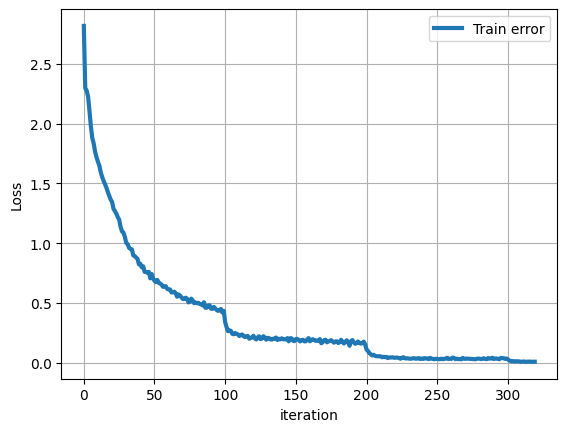

In [66]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_history)), loss_history, '-', linewidth=3, label='Train error')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()